# 3. Hands on Reinforcement Learning

## 3.2 Monte Carlo Exploring Start

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('text', usetex = True) # to use LaTeX

import gym
import numpy as np
from collections import defaultdict
from utils import plot_state_values
from utils import plot_policy

In [15]:
env = gym.make('Blackjack-v1')

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

### Monte-Carlo Exploring Starts for estimating $\pi \approx \pi^{\star}$

In [16]:
def generate_episode_from_policy(env, pi):
    state, _ = env.reset()
    episode = []
    while True:
        # select the best action according to the policy pi if it exists
        # otherwise choose 0 (arbitrary policy not changed so far)
        action = pi[state] if state in pi else 1
        next_state, reward, terminate, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminate or truncated:
            break
        
    return episode

In [17]:
# transform Q state-value function to V value function
def QtoV(Q):
    return {state: np.max(values) for state, values in Q.items()}

In [18]:
def MCES(env, generate_episode, gamma, episodes):
    n_actions = env.action_space.n
    
    # initialize arbitrarily pi, Q, returns
    pi = {}
    Q = defaultdict(lambda: np.zeros(n_actions))
    returns = {}
    
    for episode in range(episodes):
        trajectory = generate_episode(env, pi)
        G, T = 0, len(trajectory)
        
        for i in range(T-1, -1, -1):
            state, action, reward = trajectory[i]
            G += gamma**i * reward
            
            visited_state = set()
            if (state, action) not in visited_state:
                # append G to returns (s_t, a_t)
                reward, visits = returns.get((state, action), [0, 0])
                returns[(state, action)] = [reward + G, visits + 1]
                
                Q[state][action] = (reward + G) / (visits + 1)
                pi[state] = np.argmax(Q[state])
                
                visited_state.add((state, action))
    
    return Q, pi

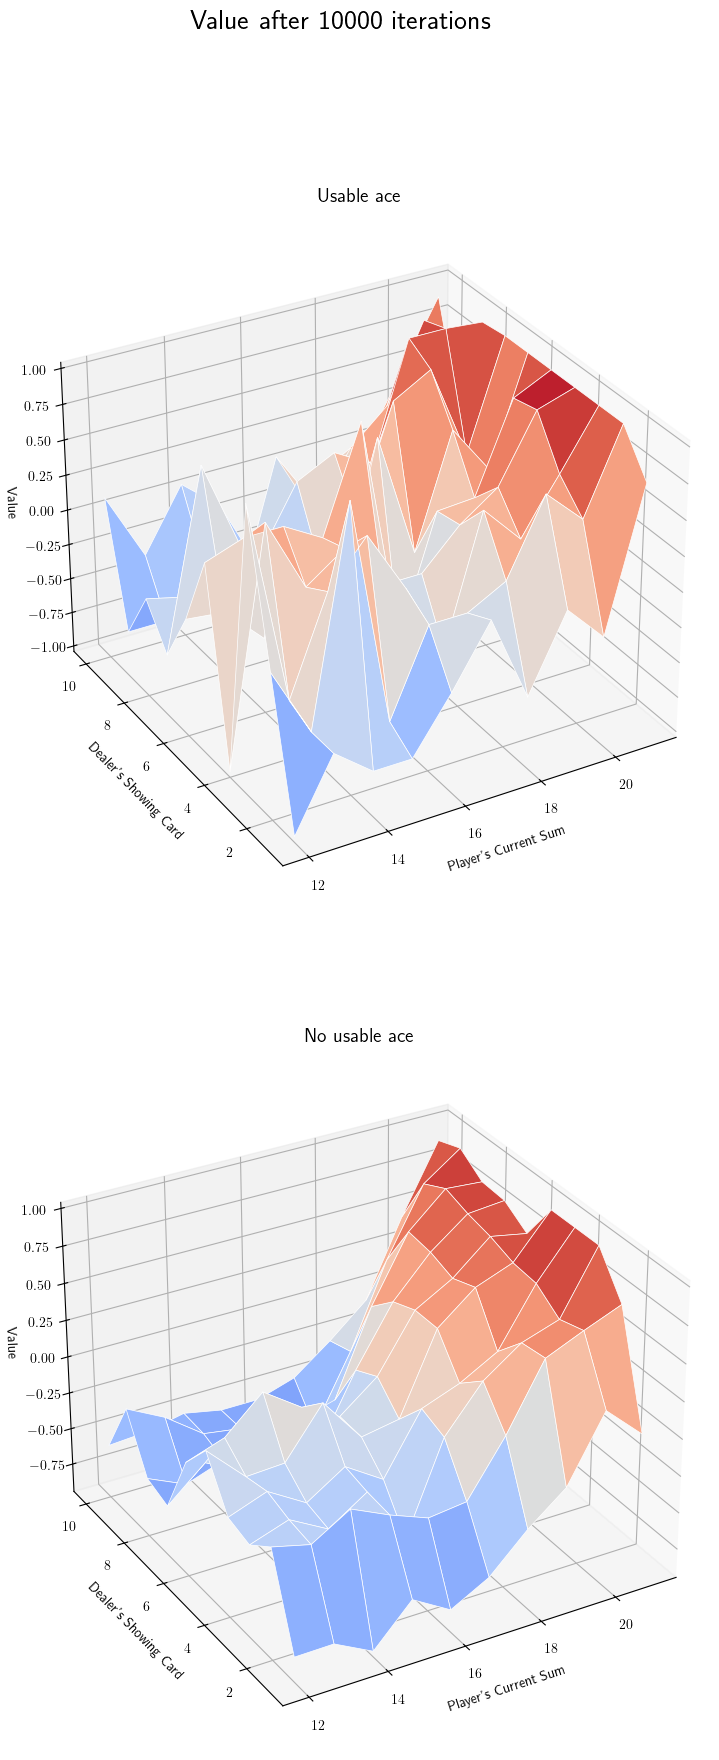

In [19]:
n_episodes = 10000
Q, pi = MCES(env, generate_episode_from_policy, 1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

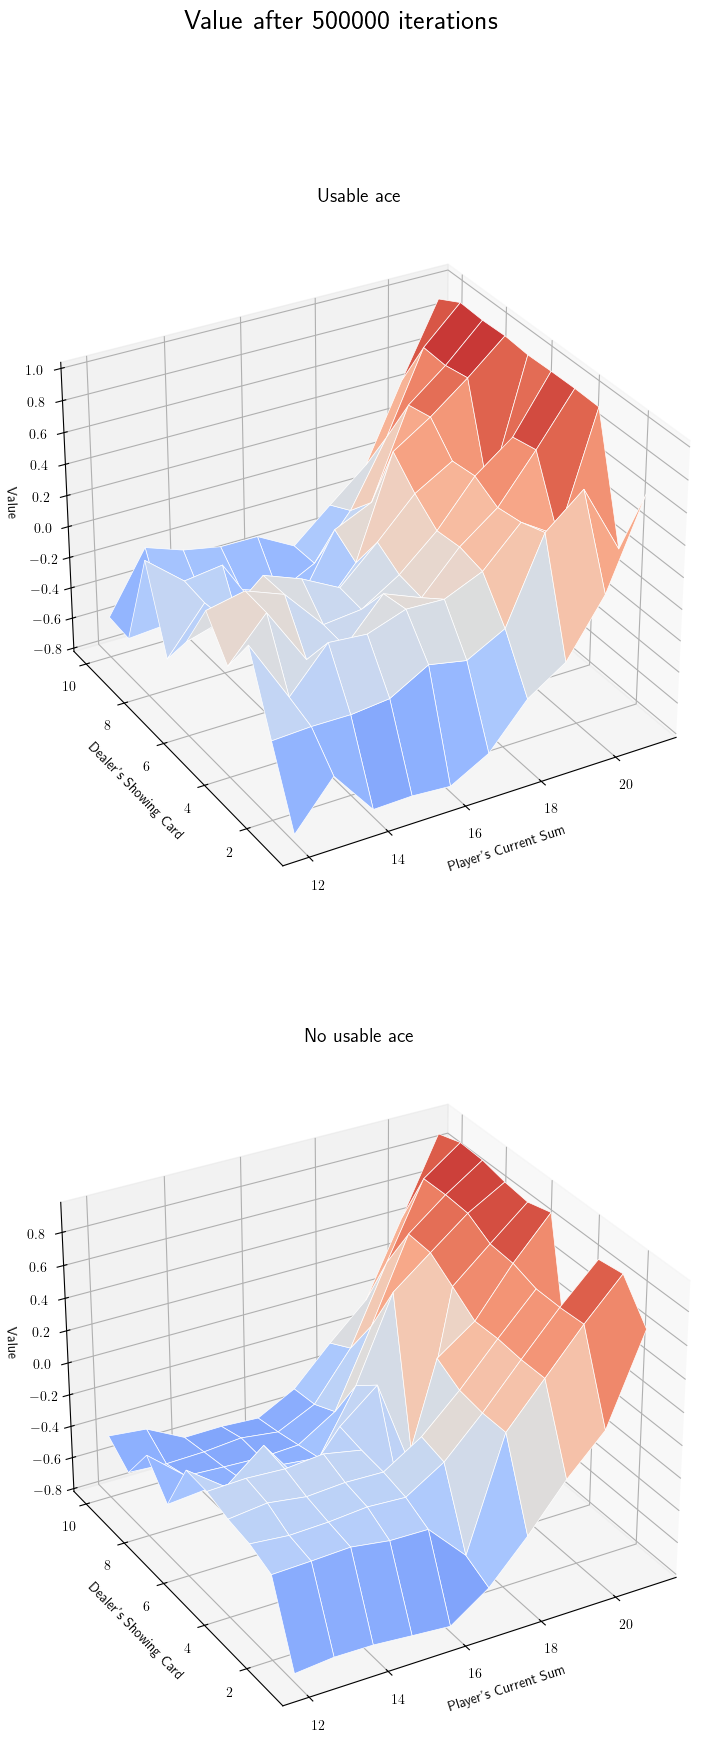

In [20]:
n_episodes = 500000
Q, pi = MCES(env, generate_episode_from_policy, 1.0, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

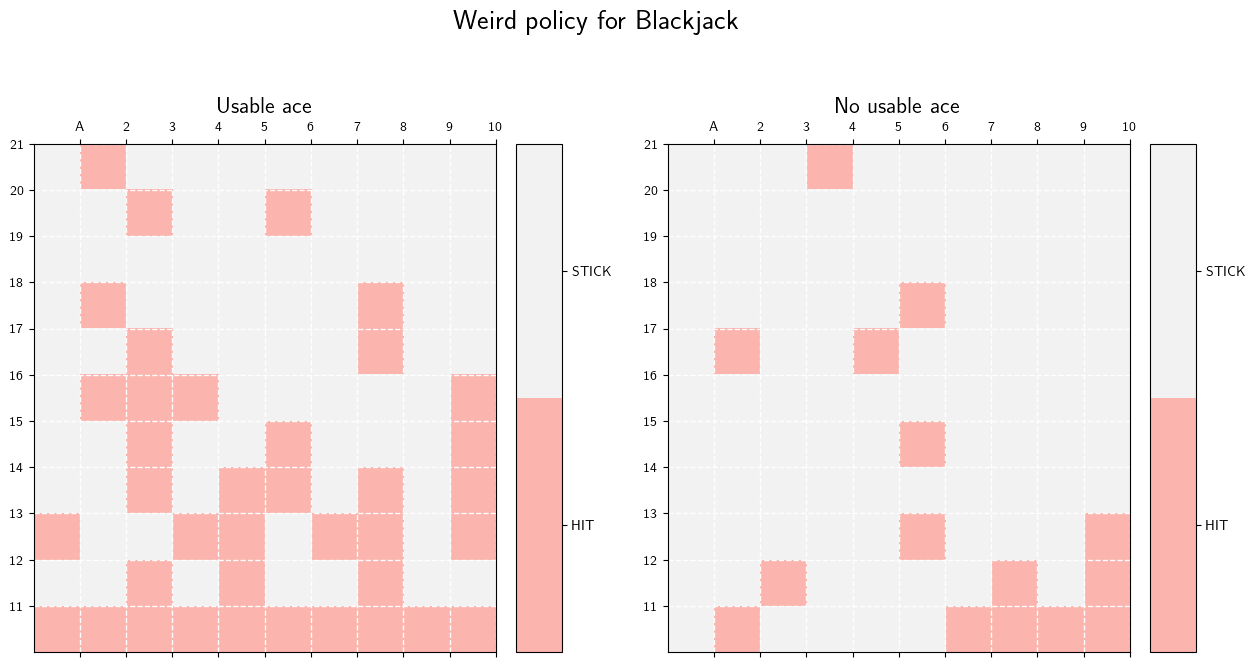

In [21]:
plot_policy(pi, "Weird policy for Blackjack")

The policy looks weird. It is because we don't explore enough. We can tackle this problem using Monte-Carlo without exploring start to balance between exploration and exploitation

### Monte-Carlo control without Exploring starts

In [22]:
# this time we need an epilon-soft policy that is to say:
# pi(a|s) > epsilon/#states for all states s so we replace
# otherwise choose 0 with np.random([0, 1]) that ensures that
# action 0 and 1 will be chosen uniformly at random if we didn't
# encounter the state s so far
def generate_episode_from_policy(env, pi):
    state, _ = env.reset()
    episode = []
    while True:
        action = np.random.choice([0, 1])
        if state in pi:
            probs = pi[state]
            action = np.random.choice(np.arange(len(probs)), p=probs)
        next_state, reward, terminate, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminate or truncated:
            break
        
    return episode

In [23]:
def MCWES(env, generate_episode, gamma, epsilon, episodes):
    n_actions = env.action_space.n # number of actions
    
    # initialize arbitrarily pi, Q, returns
    pi = defaultdict(lambda: np.zeros(n_actions))
    Q = defaultdict(lambda: np.zeros(n_actions))
    returns = {}
    
    for episode in range(episodes):
        trajectory = generate_episode(env, pi)
        G, T = 0, len(trajectory)
        
        for i in range(T-1, -1, -1):
            state, action, reward = trajectory[i]
            G += gamma**i * reward
            
            visited_state = set()
            if (state, action) not in visited_state:
                # append G to returns (s_t, a_t)
                reward, visits = returns.get((state, action), [0, 0])
                returns[(state, action)] = [reward + G, visits + 1]
                
                Q[state][action] = (reward + G) / (visits + 1)
                best_action = np.argmax(Q[state])
                
                for a in np.arange(n_actions):
                    pi[state][a] = 1 - epsilon + epsilon/n_actions if \
                            a == best_action else epsilon/n_actions
                
                visited_state.add((state, action))
    
    return Q, pi

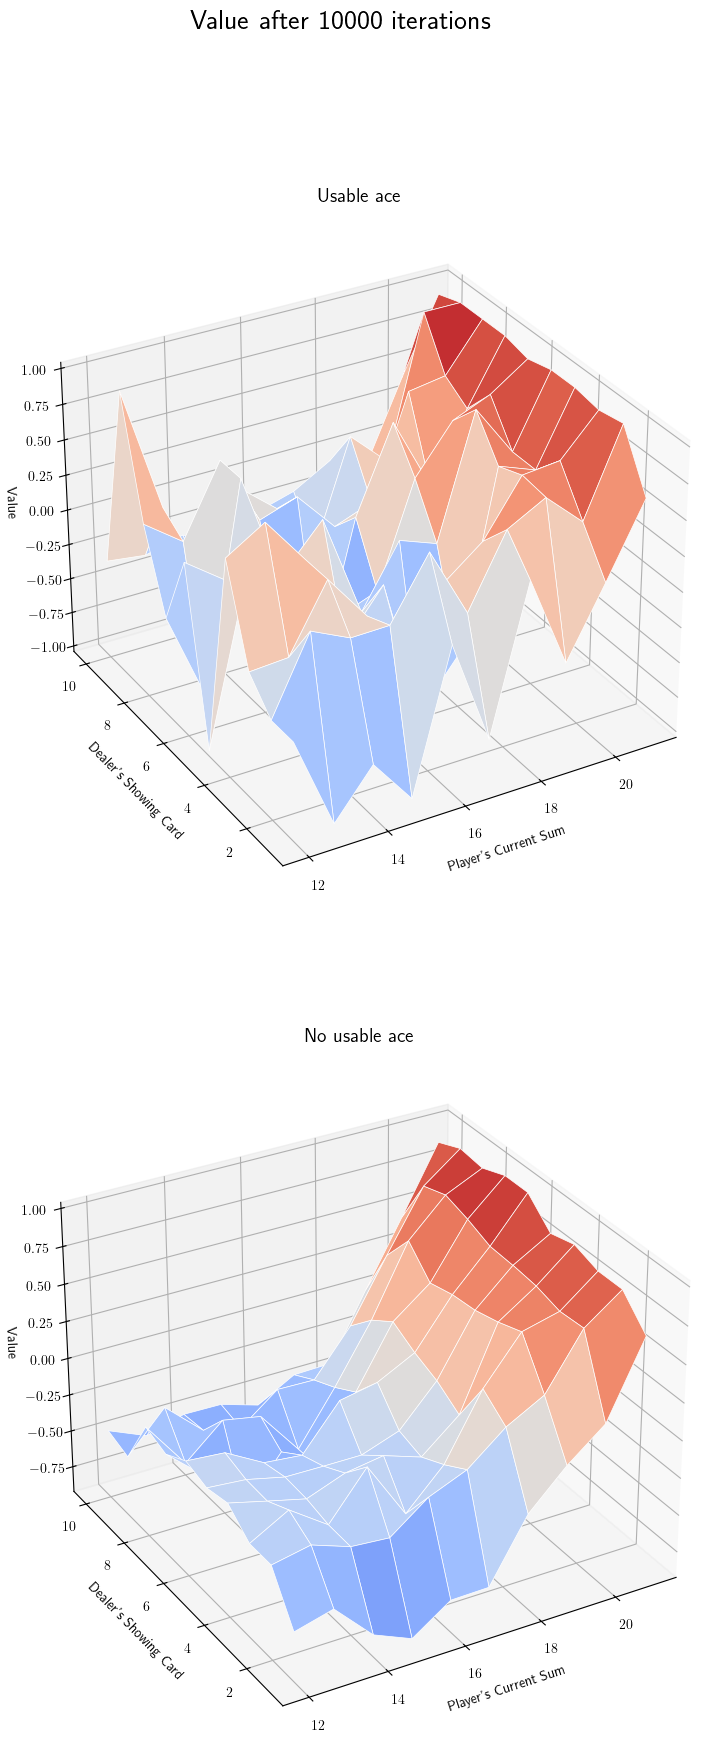

In [24]:
n_episodes = 10000
Q, pi = MCWES(env, generate_episode_from_policy, 1.0, 0.1, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

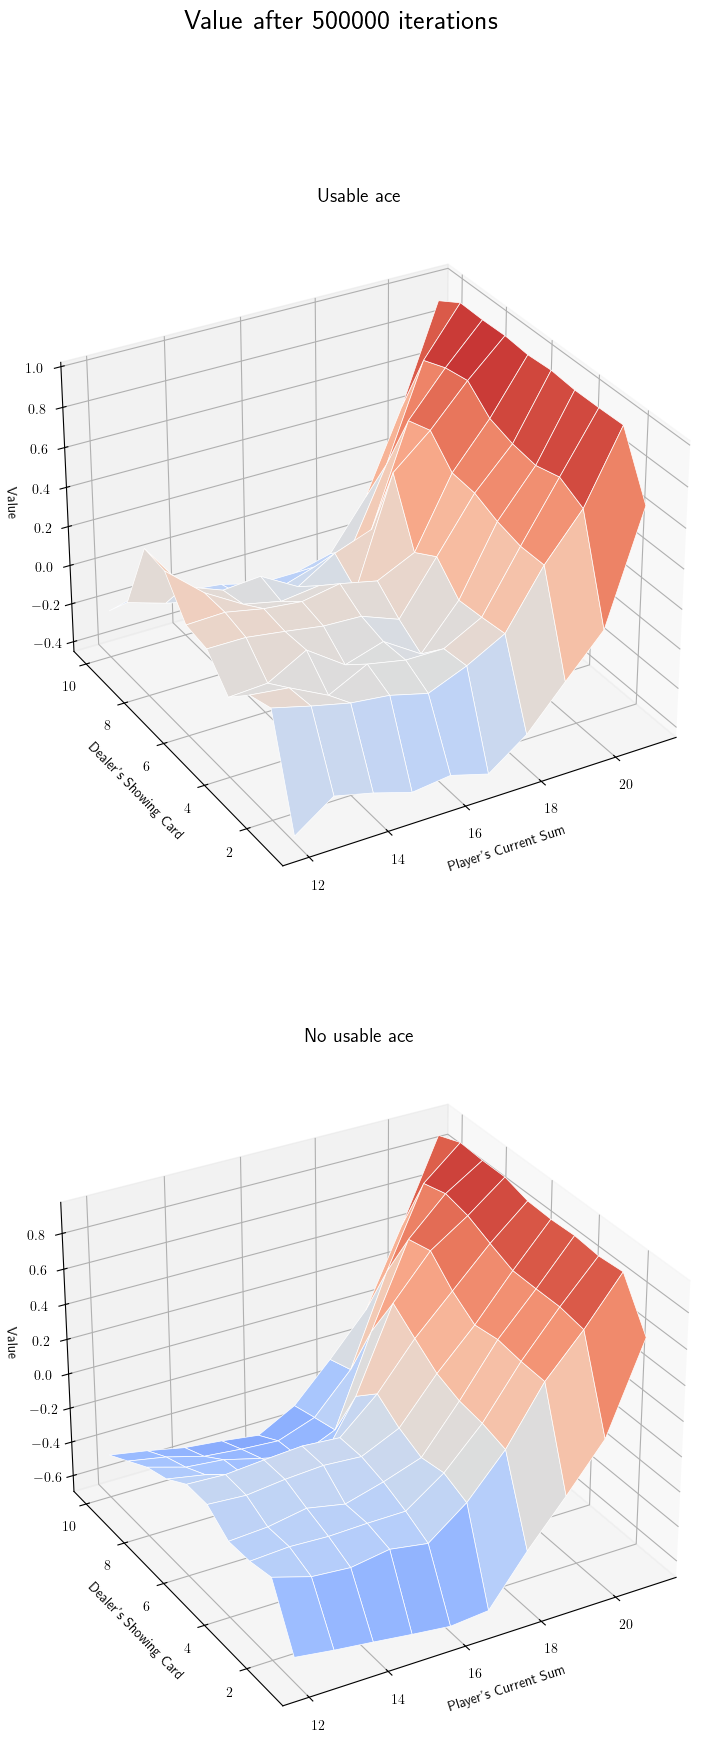

In [25]:
n_episodes = 500000
Q, pi = MCWES(env, generate_episode_from_policy, 1.0, 0.1, n_episodes)
V = QtoV(Q)
plot_state_values(V, n_episodes)

In [26]:
# convert stochastic policy to deterministic policy
deter_pi = {state: np.argmax(values) for state, values in pi.items()}

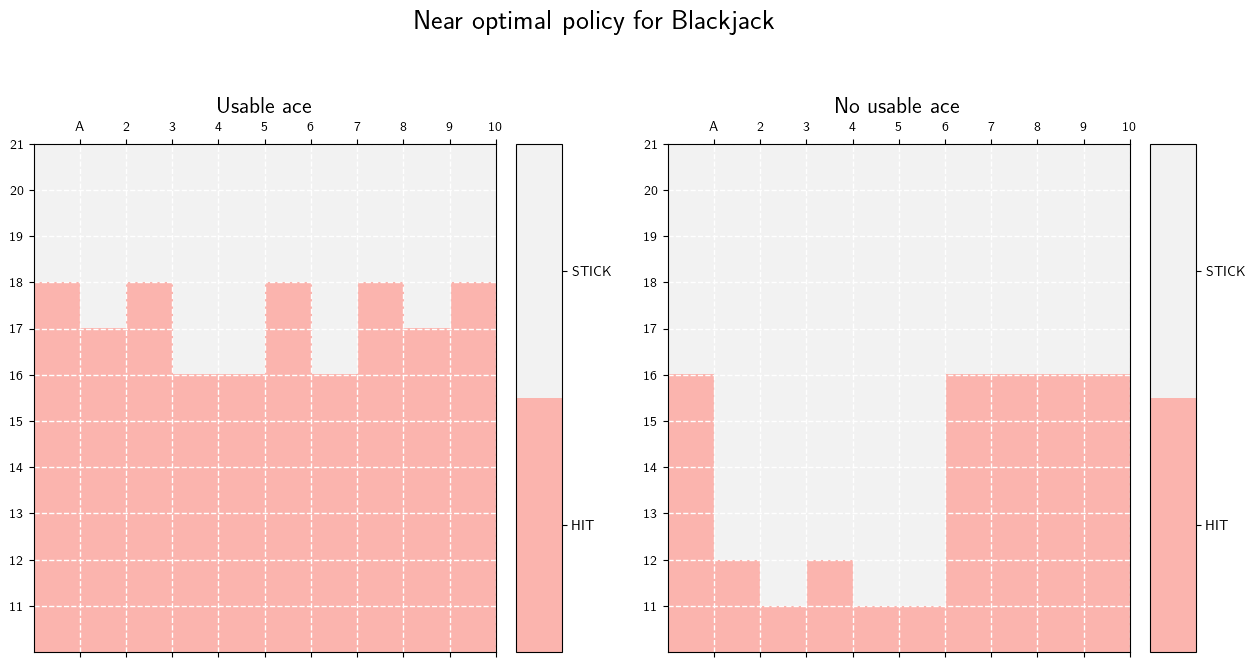

In [27]:
plot_policy(deter_pi, "Near optimal policy for Blackjack")

In [37]:
def evaluate_policy(env, policy, num_episodes=100, seed=None):
    """
    Evaluate the policy in the environment.
    参数：
        env: Gym/Gymnasium
        policy: policy dict, {player_sum, dealer_card, usable_ace: action}
        num_episodes: number of episodes to evaluate
        seed: 
    Return：
        win_rate
        lose_rate
        draw_rate
    """
    results = {
        'win': 0,
        'lose': 0,
        'draw': 0,
        'unknown': 0
    }
    
    for episode in range(num_episodes):
        state, _ = env.reset(seed=seed+episode if seed else None)
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            if state in policy:
                action = policy[state]
            else:
                action = 1 if state[0] < 18 else 0
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
        
        if reward == 1:
            results['win'] += 1
        elif reward == -1:
            results['lose'] += 1
        elif reward == 0:
            results['draw'] += 1
        else:
            results['unknown'] += 1
    
    total = sum(results.values())
    return {
        'win_rate': results['win'] / total,
        'lose_rate': results['lose'] / total,
        'draw_rate': results['draw'] / total,
        'raw_counts': results
    }


env = gym.make('Blackjack-v1', natural=False, sab=False)
results = evaluate_policy(env, deter_pi, num_episodes=1000, seed=42)
print(f"Evaluation results:")
print(f"winning times: {results['raw_counts']['win']} win rate: {results['win_rate']*100:.1f}%")
print(f"losing times: {results['raw_counts']['lose']} lose rate: {results['lose_rate']*100:.1f}%")
print(f"draw times: {results['raw_counts']['draw']} draw rate: {results['draw_rate']*100:.1f}%")

Evaluation results:
winning times: 444 win rate: 44.4%
losing times: 472 lose rate: 47.2%
draw times: 84 draw rate: 8.4%
